In [28]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Input

from sklearn import svm
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix,accuracy_score, classification_report, r2_score

In [29]:
df = pd.read_csv("../../SleepEfficiency/Dataset/Sleep_Efficiency.csv")

new_columns = ['id', 'age', 'gender','bed_time', 'wakeup_time', 'sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake',
               'caffeine', 'alcohol', 'smoke_stat', 'exercise_freq']
df.columns = new_columns
df = df.drop(columns=['id','bed_time', 'wakeup_time'])
df.sample(5)

,age,gender,sleep_dur,sleep_eff,rem_per,deep_per,light_per,awake,caffeine,alcohol,smoke_stat,exercise_freq
252,23,Female,7.0,0.54,18,35,45,1.0,50.0,5.0,Yes,1.0
21,32,Male,7.5,0.71,22,58,19,3.0,50.0,4.0,No,1.0
406,53,Male,7.0,0.82,15,62,18,2.0,0.0,0.0,No,3.0
331,46,Male,8.0,0.72,18,70,10,3.0,0.0,0.0,Yes,3.0
67,52,Male,7.5,0.87,18,70,10,0.0,25.0,2.0,No,1.0


In [30]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            452 non-null    int64  
 1   gender         452 non-null    object 
 2   sleep_dur      452 non-null    float64
 3   sleep_eff      452 non-null    float64
 4   rem_per        452 non-null    int64  
 5   deep_per       452 non-null    int64  
 6   light_per      452 non-null    int64  
 7   awake          432 non-null    float64
 8   caffeine       427 non-null    float64
 9   alcohol        436 non-null    float64
 10  smoke_stat     452 non-null    object 
 11  exercise_freq  446 non-null    float64
dtypes: float64(6), int64(4), object(2)
memory usage: 42.5+ KB
None


,age,sleep_dur,sleep_eff,rem_per,deep_per,light_per,awake,caffeine,alcohol,exercise_freq
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,436.000000,446.000000
mean,40.285398,7.465708,0.788916,23.002212,52.960177,24.831858,1.641204,23.653396,1.245413,1.791480
std,13.172250,0.866625,0.135237,3.972466,15.561713,15.150774,1.356762,30.202785,1.643336,1.428134
min,9.000000,5.000000,0.500000,15.000000,20.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,7.000000,0.697500,20.000000,51.250000,15.000000,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.500000,0.820000,22.000000,60.000000,18.000000,1.000000,25.000000,0.000000,2.000000
75%,52.000000,8.000000,0.900000,27.000000,63.000000,27.250000,3.000000,50.000000,2.000000,3.000000
max,69.000000,10.000000,0.990000,30.000000,75.000000,56.000000,4.000000,200.000000,5.000000,5.000000


In [31]:
numerical_columns = [column for column in df.columns if df[column].dtype != 'object']
print(numerical_columns)

categorical_columns = [column for column in df.columns if df[column].dtype == 'object']
print(categorical_columns)

['age', 'sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake', 'caffeine', 'alcohol', 'exercise_freq']
['gender', 'smoke_stat']


In [32]:
def set_fillna(df, numerical_columns):
    df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
    return df

df = set_fillna(df, numerical_columns)

In [33]:
def set_types(df):
    # df['id']            = df['id'].astype('int16')
    df['age']           = df['age'].astype('int8')
    df['gender']        = df['gender'].astype('category')
    # df['bed_time']      = pd.to_datetime(df['bed_time'])
    # df['wakeup_time']   = pd.to_datetime(df['wakeup_time'])
    df['sleep_dur']     = df['sleep_dur'].astype('float16')
    df['sleep_eff']     = df['sleep_eff'].astype('float16')
    df['rem_per']       = df['rem_per'].astype('int8')
    df['deep_per']      = df['deep_per'].astype('int8')
    df['light_per']     = df['light_per'].astype('int8')
    df['awake']         = df['awake'].astype('int8')
    df['caffeine']      = df['caffeine'].astype('int8')
    df['alcohol']       = df['alcohol'].astype('int8')
    df['smoke_stat']    = df['smoke_stat'].map({'Yes': 1, 'No':0}).astype('int8')
    df['exercise_freq'] = df['exercise_freq'].astype('int8')
    return df

df = set_types(df)

In [35]:
# numerical_feature = ['sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake', 'caffeine', 'alcohol', 'smoke_stat', 'exercise_freq']
# categorical_feature = ['gender']

numerical_columns = [column for column in df.columns if df[column].dtype != 'category']
print(numerical_columns)

categorical_columns = [column for column in df.columns if df[column].dtype == 'category']
print(categorical_columns)

['age', 'sleep_dur', 'sleep_eff', 'rem_per', 'deep_per', 'light_per', 'awake', 'caffeine', 'alcohol', 'smoke_stat', 'exercise_freq']
['gender']


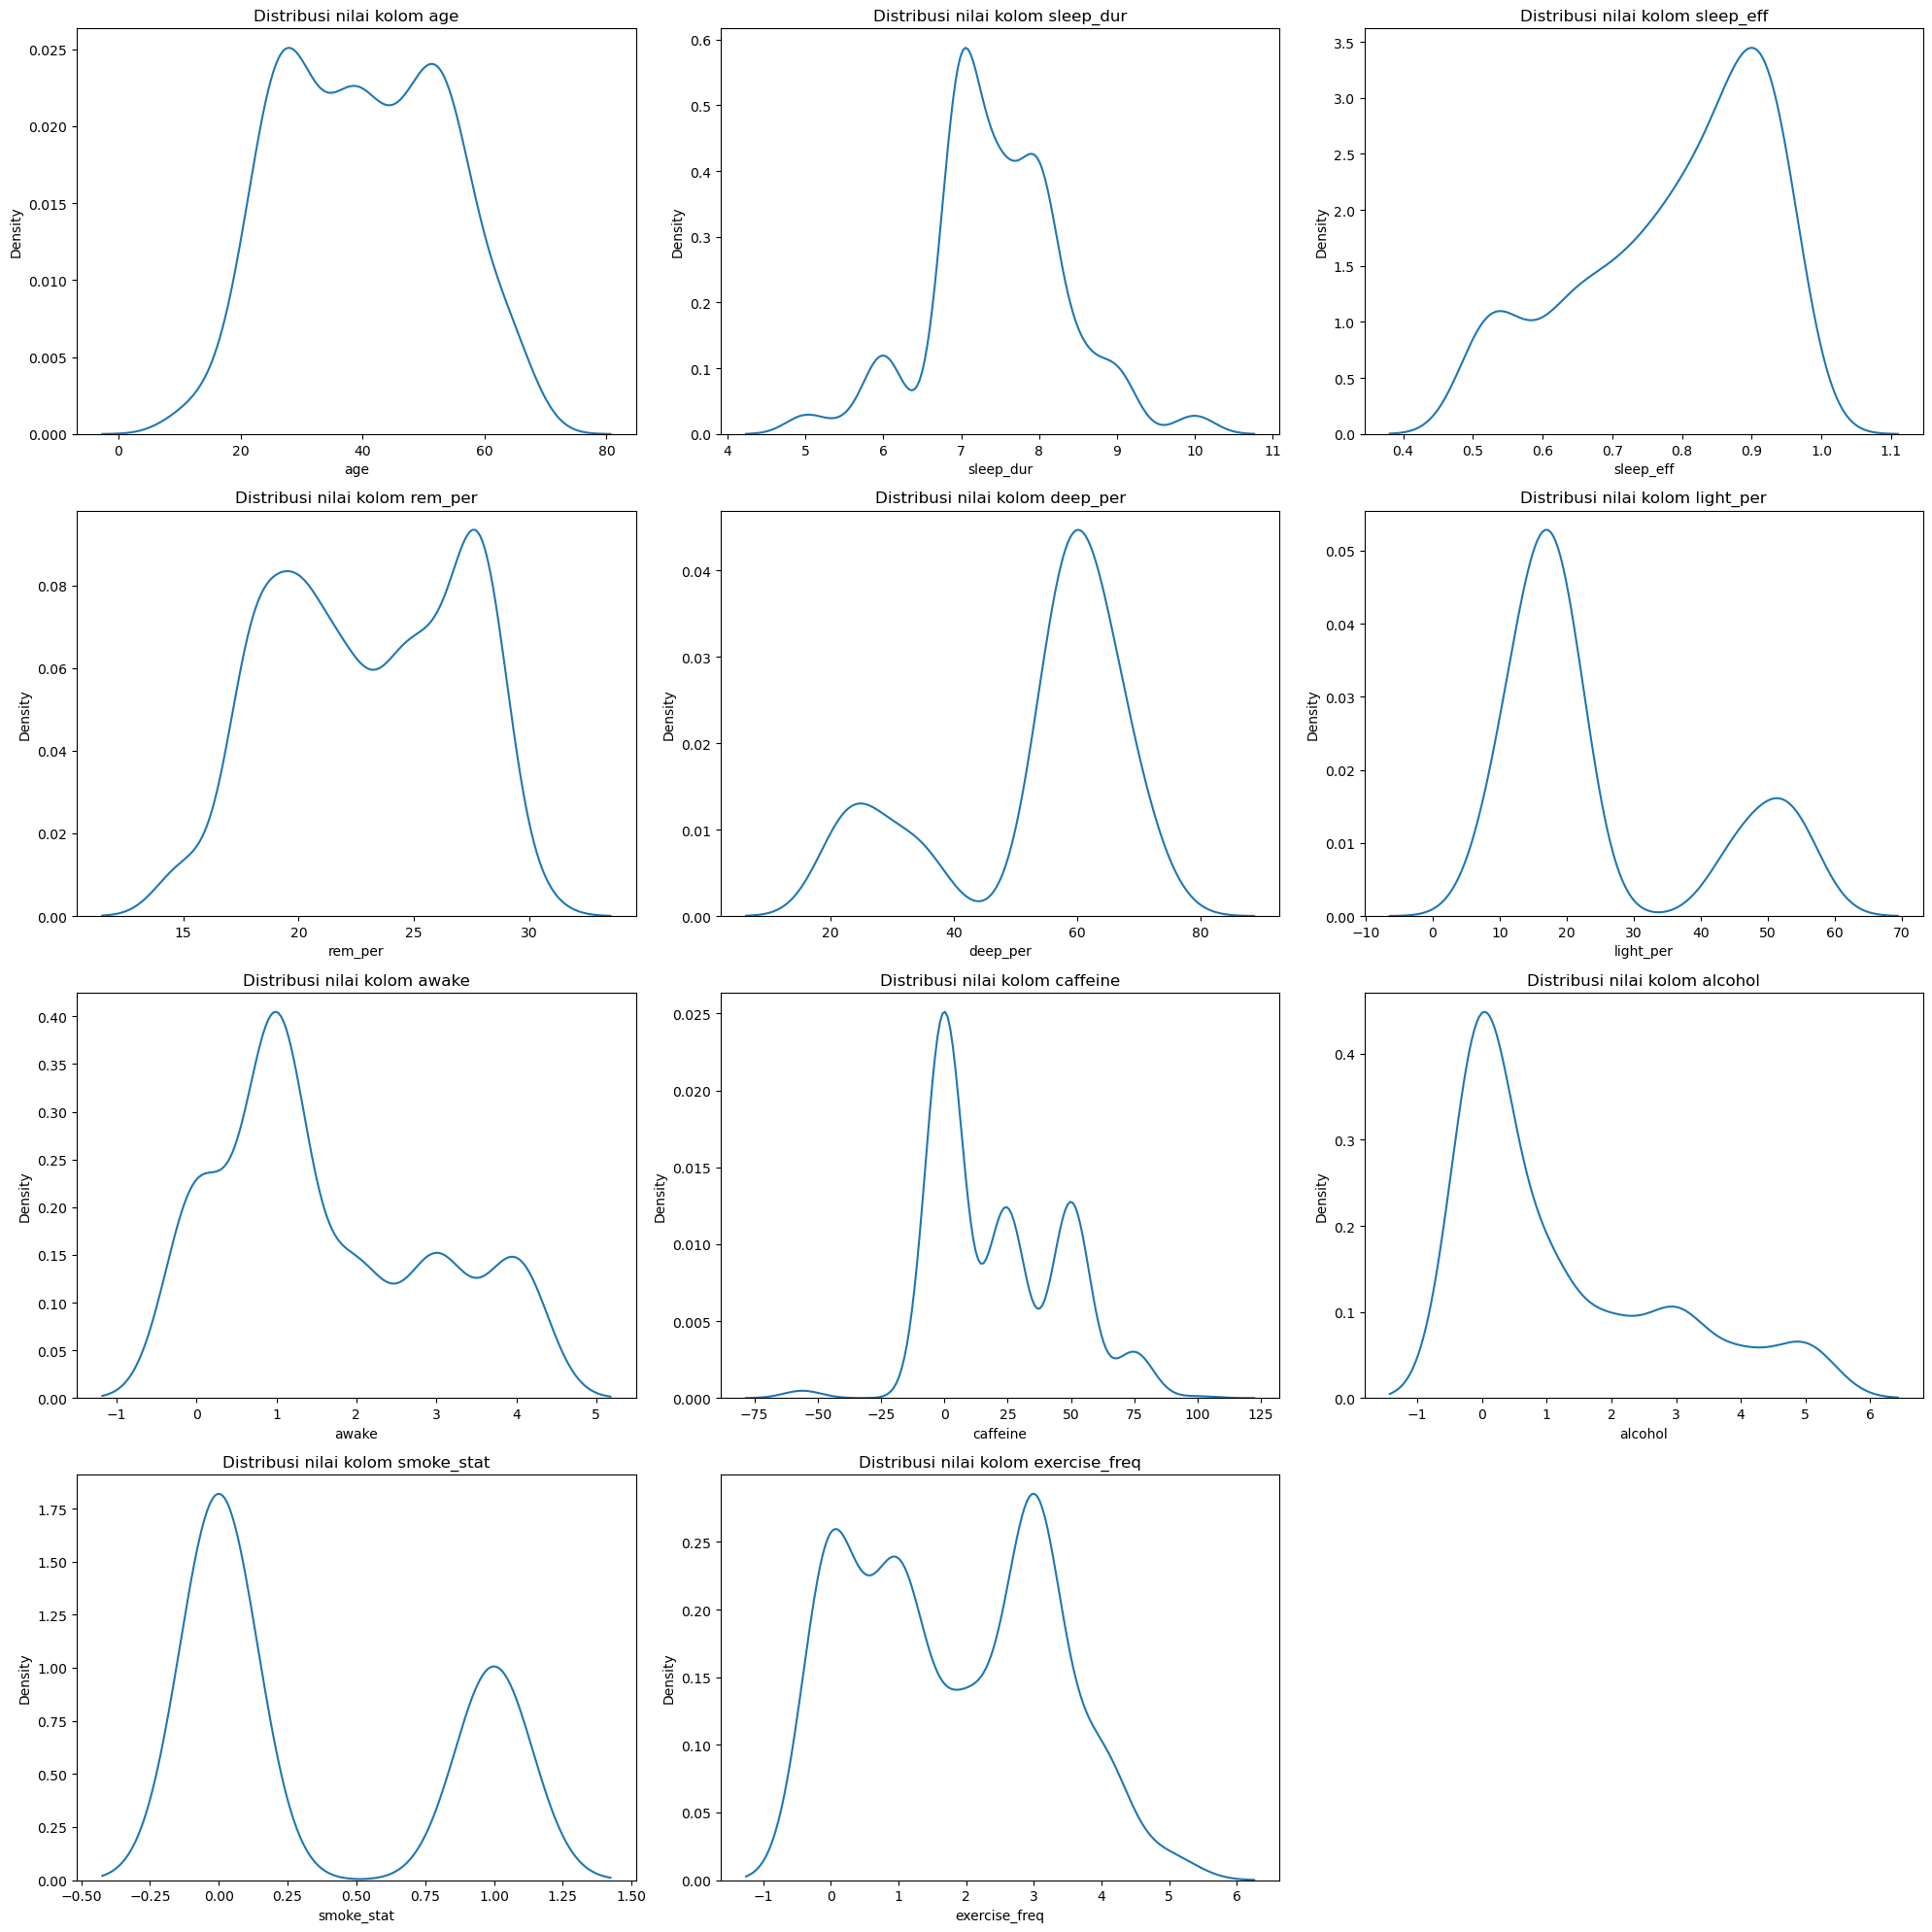

In [37]:
num_rows = 4
num_cols = math.ceil(len(numerical_columns) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=df, x=column, ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

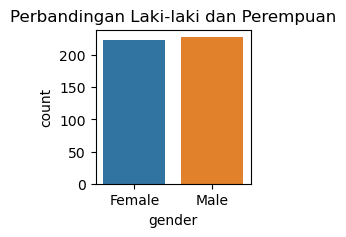

In [38]:
for column in categorical_columns:
    plt.figure(figsize=(2,2))
    sns.countplot(x=df[column]).set_title("Perbandingan Laki-laki dan Perempuan")
    plt.show()

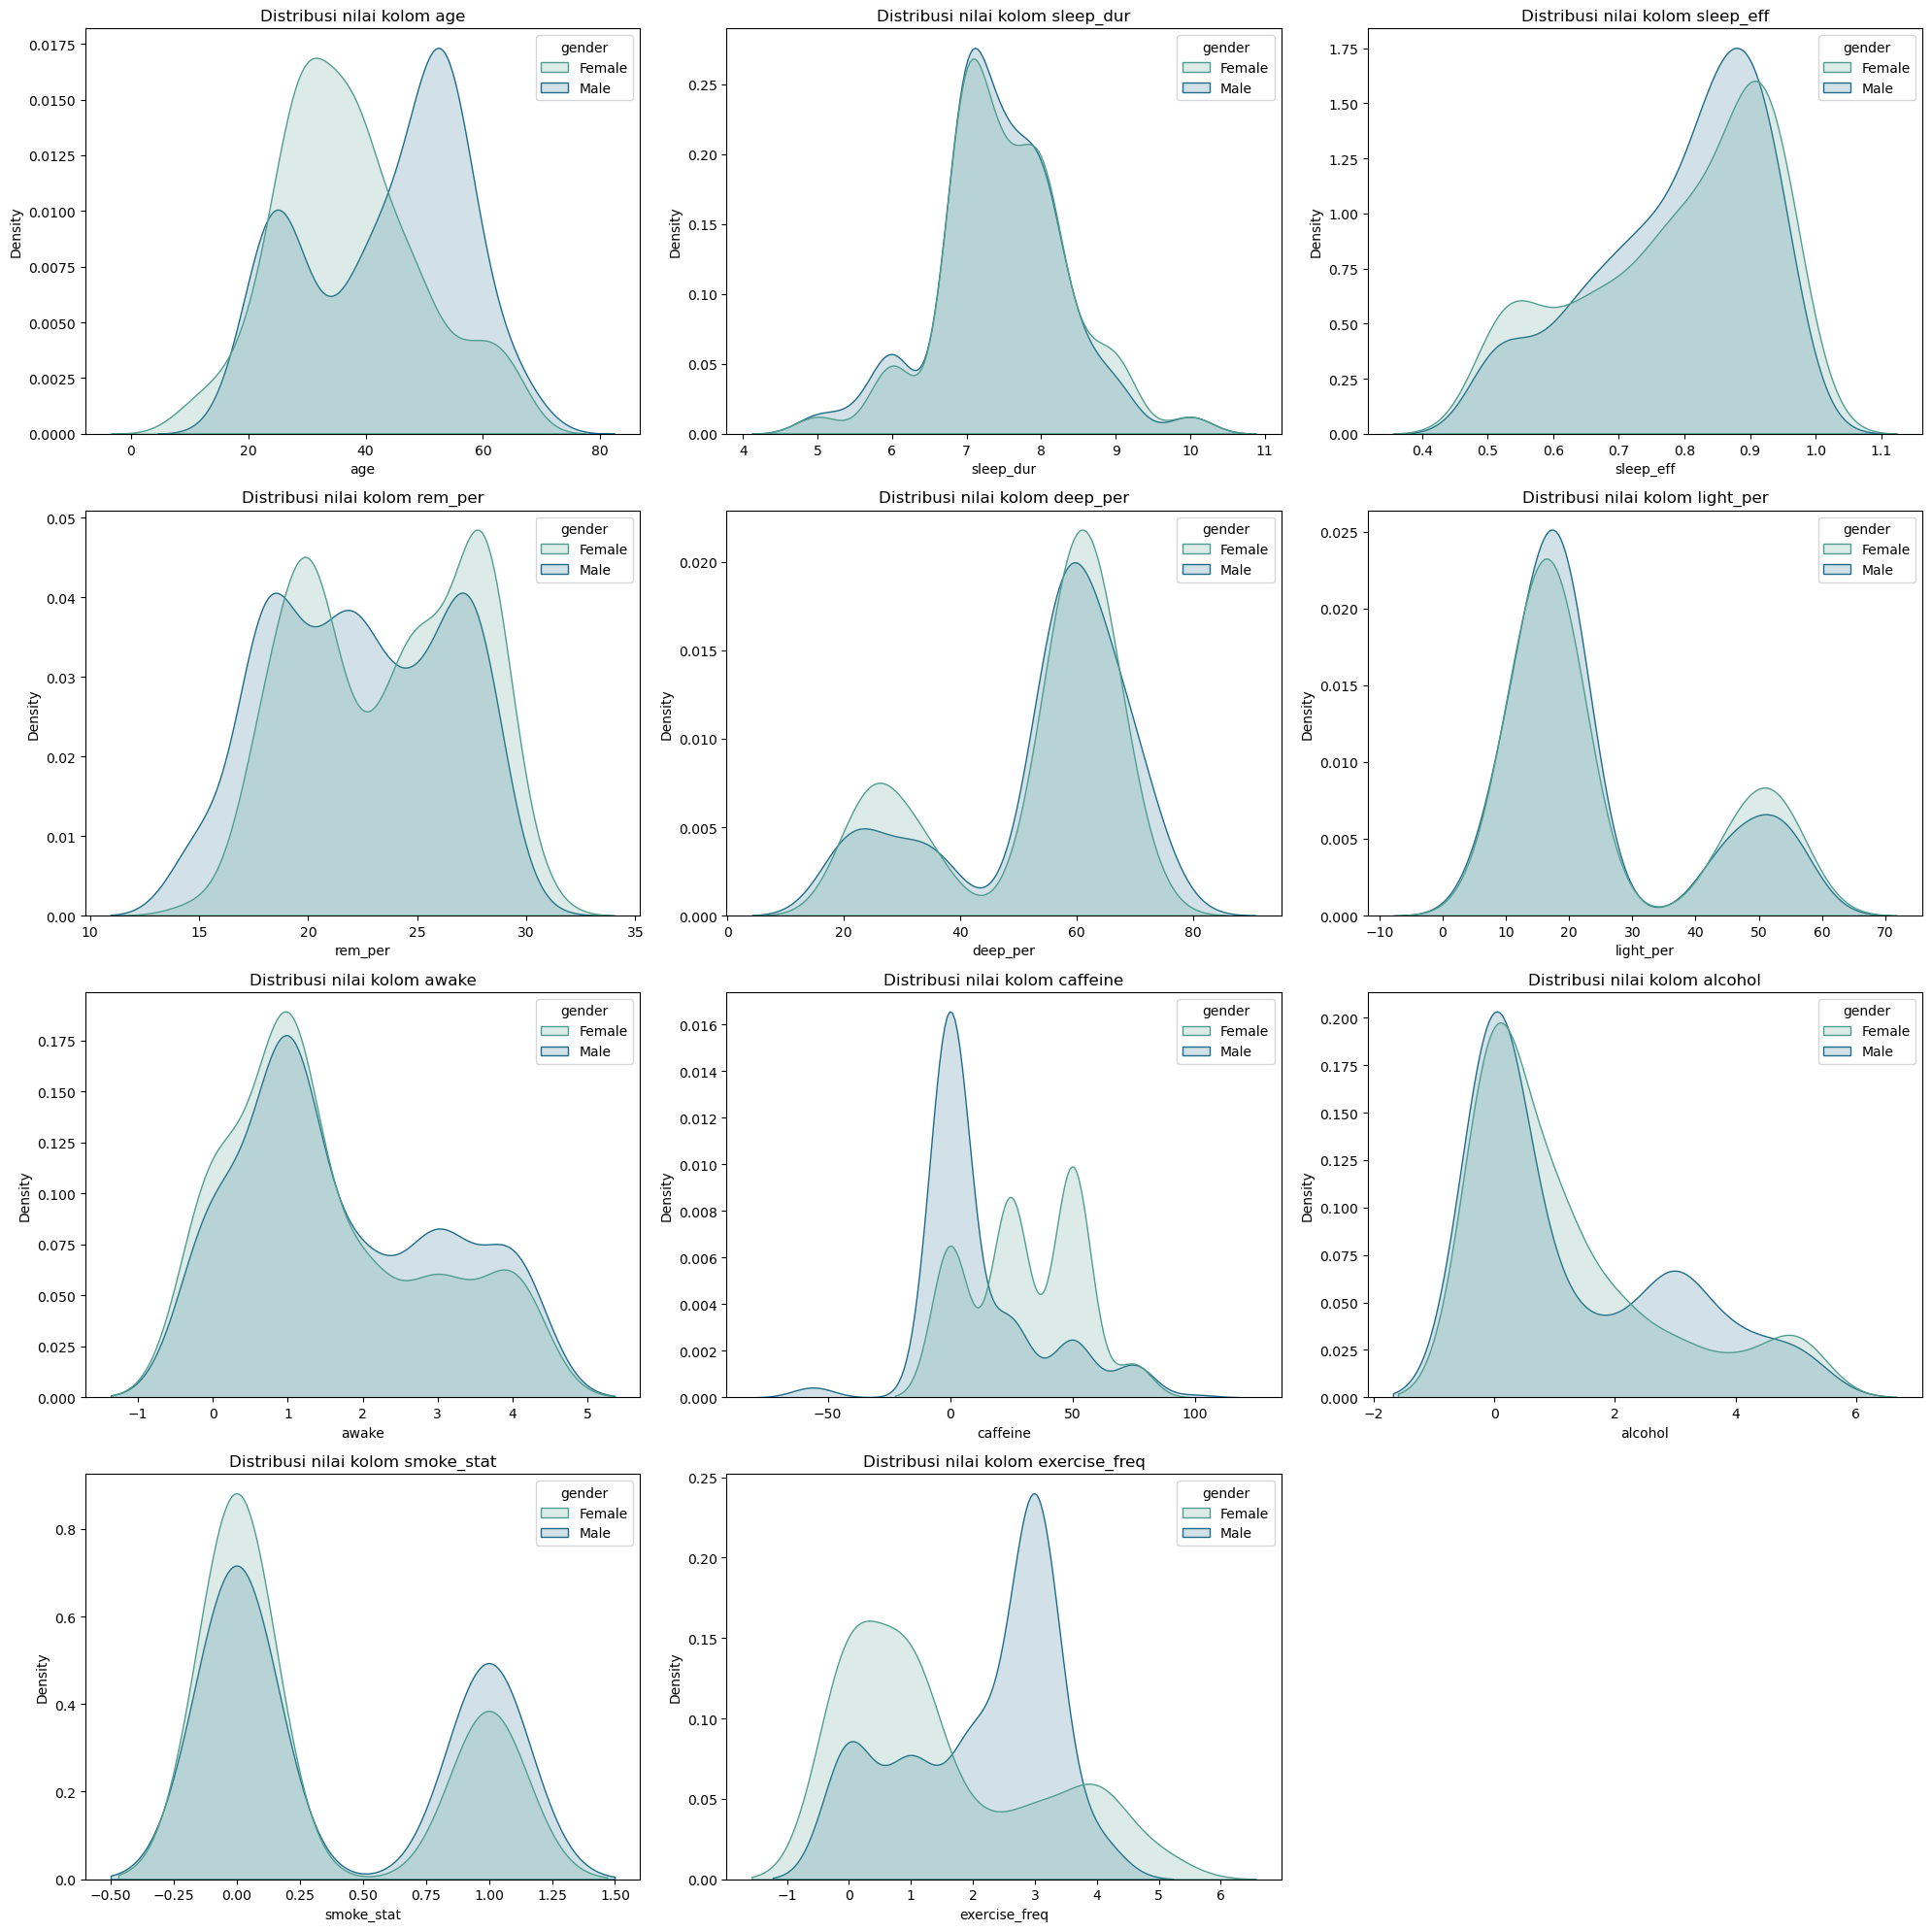

In [39]:
num_rows = 4
num_cols = math.ceil(len(numerical_columns) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=df, x=column, hue="gender", fill=True, alpha=.2, palette="crest", ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

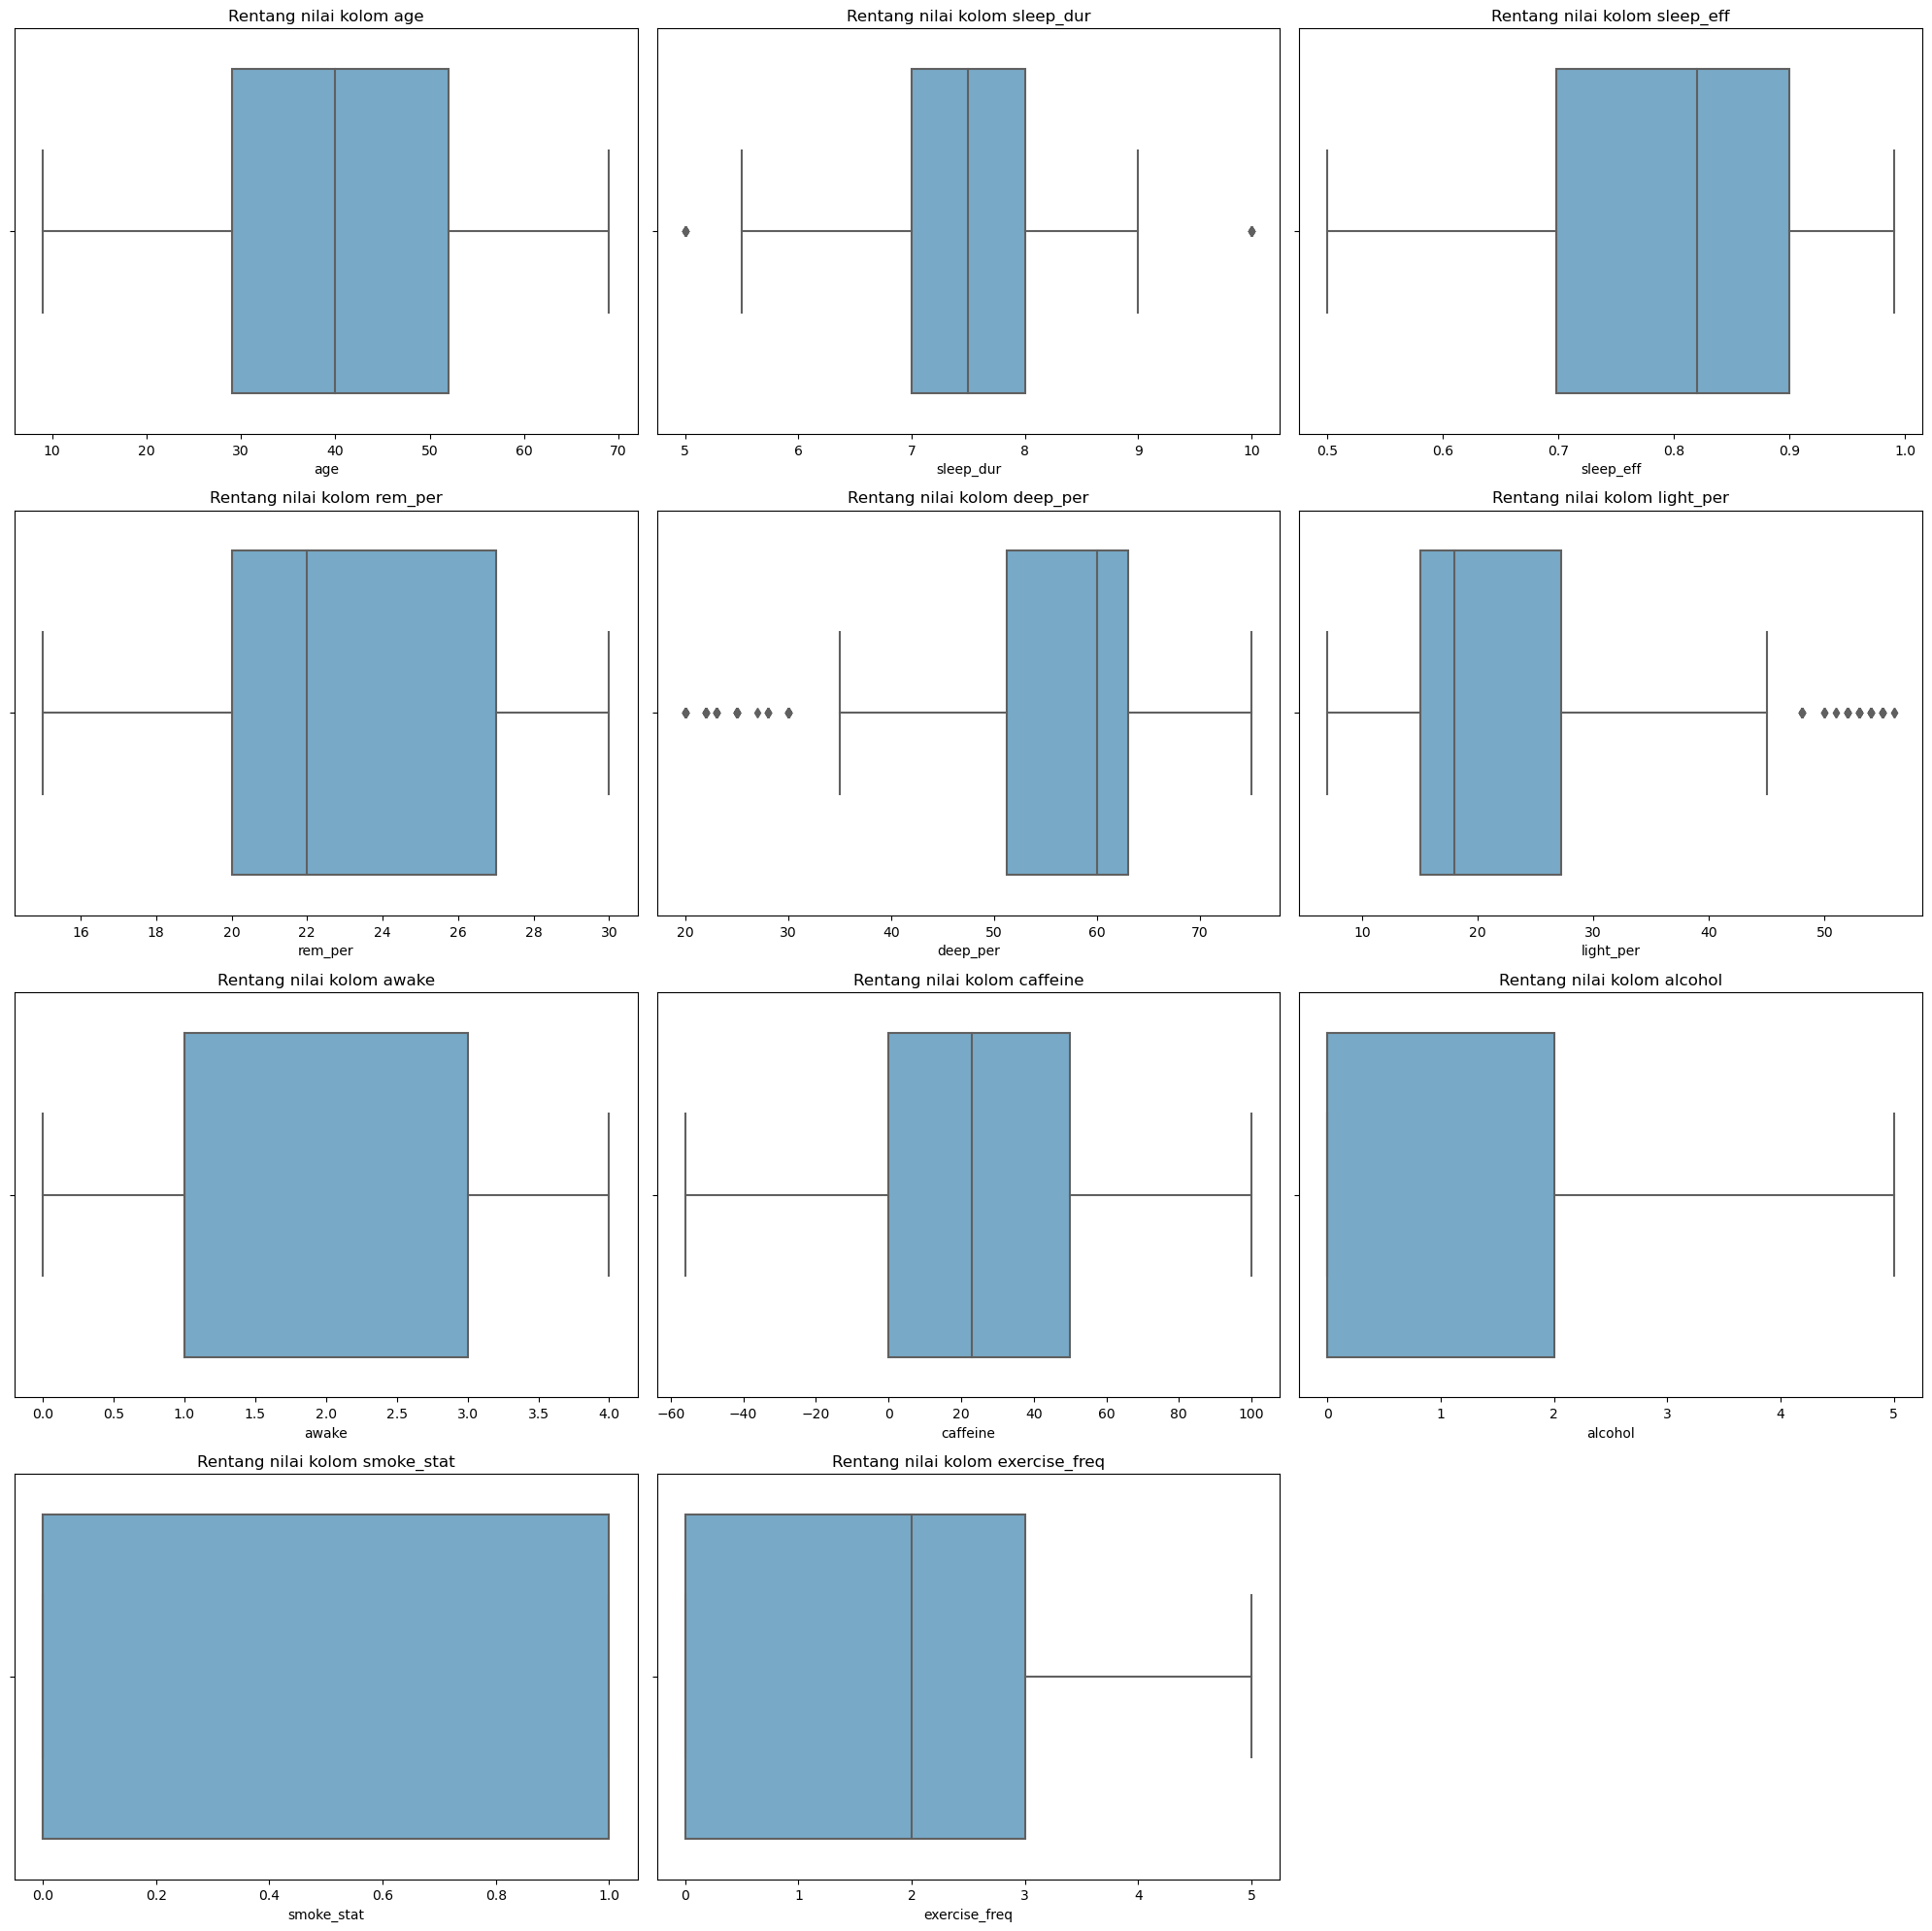

In [44]:
num_rows = 4
num_cols = math.ceil(len(numerical_feature) / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
for i, column in enumerate(numerical_feature):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=df[column], ax=axes[row, col], palette="Blues").set_title("Rentang nilai kolom " + column)
    
for i in range(len(numerical_feature), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

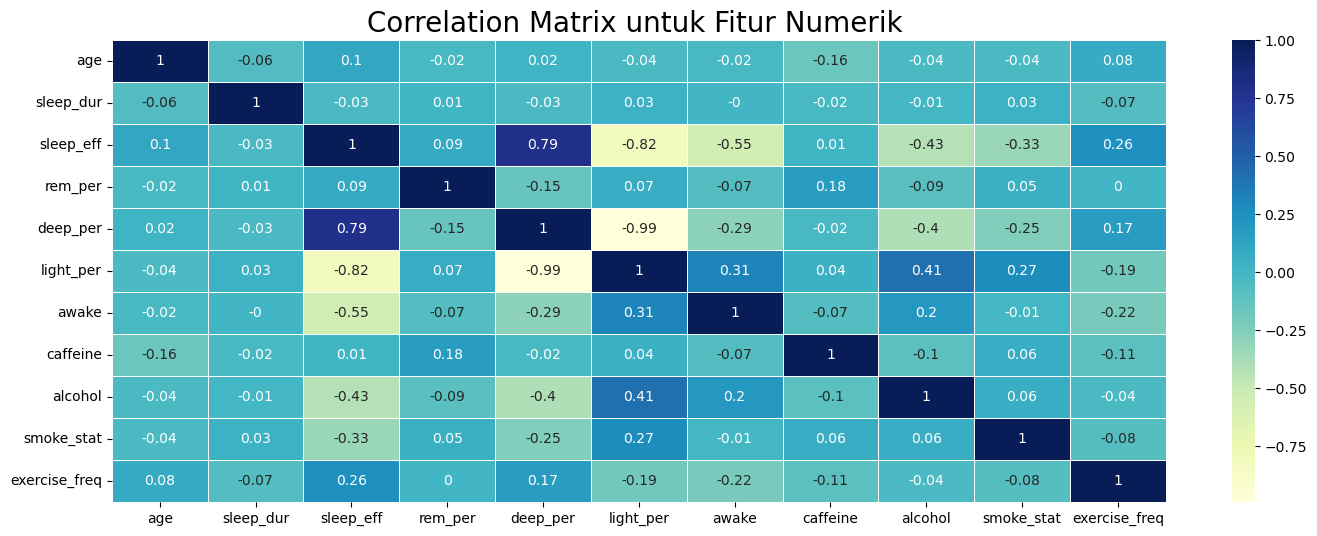

In [42]:
corr_matrix = df[numerical_feature].corr().round(2)

plt.figure(figsize=(17, 6))
sns.heatmap(data=corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

In [12]:
feature = ['rem_per', 'deep_per', 'light_per', 'awake', 'alcohol','smoke_stat','exercise_freq']
target = ['sleep_eff']

In [53]:
X = df[numerical_columns].drop(columns='sleep_eff')
Y = df['sleep_eff']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 452
Total # of sample in train dataset: 316
Total # of sample in test dataset: 136


In [54]:
def regression_algorithms():
    algorithms = [
                  ('Linear Regression', LinearRegression()), 
                  ('SVR', SVR(kernel='rbf')), 
                  ('KNN', KNeighborsRegressor(n_neighbors=5)), 
                  ('Decision Tree', DecisionTreeRegressor(max_depth=14)),
                  ('GradientBoosting', GradientBoostingRegressor(n_estimators=11758, learning_rate=0.1, random_state=42)),
                  ('MLP',MLPRegressor(hidden_layer_sizes=(20000,), max_iter=70, random_state=42))
                  ]
    return algorithms

def prepare_regression_model(algorithm):
    model = algorithm
    model.fit(X_train, y_train.values.ravel())
    return model

def calculate_regression_performance(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = round(model.score(X_train,y_train), 4)*100
    mse = round(mean_squared_error(y_test, y_pred), 4)
    r2  = round(r2_score(y_test, y_pred), 4)

    return acc, mse, r2

def regression_result(result, name, acc, mse, r2):
    result.append((name, acc, mse, r2))
    return result

In [55]:
%%time
result = []

algorithms = regression_algorithms()

for index, tup in enumerate(algorithms):
    model = prepare_regression_model(tup[1])

    # Calculate the Accuracy, Mean Squared Error (MSE), and R-squared score
    acc, mse, r2= calculate_regression_performance(model,X_train, y_train, X_test, y_test)
    result = regression_result(result, tup[0], acc, r2, mse)

regression_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy (%)', 'R-Square', 'MSE'))
regression_results_df

CPU times: total: 20.8 s
Wall time: 8.84 s


,Model Name,Accuracy (%),R-Square,MSE
0,Linear Regression,81.19,0.8231,0.003599
1,SVR,77.19,0.7658,0.004800
2,KNN,87.49,0.8656,0.002701
3,Decision Tree,99.82,0.8171,0.003700
4,GradientBoosting,100.00,0.8236,0.003600
5,MLP,91.62,0.7646,0.004800


In [59]:
def DNN_Model():
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    dnn_model.add(Dense(32, activation='relu'))
    dnn_model.add(Dense(1, activation='sigmoid'))
    dnn_model._name = 'DNN_Model'
    return dnn_model

def CNN_Model():
    cnn_model = Sequential()
    cnn_model.add(Conv1D(2048, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model._name = 'CNN_Model'
    return cnn_model

def LSTM_Model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=32, input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dense(units=1))
    lstm_model._name = 'LSTM_Model'
    return lstm_model

def GRU_Model():
    gru_model = Sequential()
    gru_model.add(GRU(units=32, input_shape=(X_train.shape[1], 1)))
    gru_model.add(Dense(units=1))
    gru_model._name = 'GRU_Model'
    return gru_model

def Autoencoder_Model():
    # define the input shape and input layer
    input_shape = (X_train.shape[1],)
    input_layer = Input(shape=input_shape)
    encoded_layer = Dense(256, activation='relu')(input_layer)
    encoded_layer = Dense(64, activation='relu')(encoded_layer)
    decoded_layer = Dense(16, activation='relu')(encoded_layer)
    decoded_layer = Dense(input_shape[0], activation='sigmoid')(decoded_layer)

    # define the Autoencoder model
    autoencoder_model = Model(input_layer, decoded_layer)
    autoencoder_model._name = 'Autoencoder_Model'

    # compile the Autoencoder model and fit the Autoencoder model to the data
    autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    autoencoder_model.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_test, X_test), verbose=0)
    return autoencoder_model

def NN_Algorithms():
    nn_algorithms = [
        ('DNN', DNN_Model()),
        ('CNN', CNN_Model()),
        ('LSTM', LSTM_Model()),
        ('GRU', GRU_Model()),
        ('Autoencoder', Autoencoder_Model())
    ]
    return nn_algorithms
    

def compile_train_model(model, X_train, y_train, X_test, y_test):
    # Compile the model
    # model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    return model 

def evaluate_model(model, X_test, y_test):
    acc = 'null'
    y_pred  = model.predict(X_test)

    if(model._name == 'Autoencoder_Model'):
      r2  = round(r2_score(X_test, y_pred), 4)
      mse = round(mean_squared_error(X_test, y_pred), 4)
    else:
      r2  = round(r2_score(y_test, y_pred), 4)
      mse = round(mean_squared_error(y_test, y_pred), 4)
    
    # print('Model Name :', model.name)
    # print('R-Squared  :', r2)
    # print('MSE        :', round(mse, 4))

    return acc, mse, r2

def NN_result(result, name, acc, r2, mse):
    result.append((name, acc, r2, mse))
    return result

In [62]:
%%time
result = []

algorithms = NN_Algorithms()

for index, model in enumerate(algorithms):
    print(model[0])
    if(model[0] == 'Autoencoder'):
        nn_model = model[1]
    else:    
        nn_model = compile_train_model(model[1], X_train, y_train, X_test, y_test)
        
    acc, mse, r2= evaluate_model(nn_model, X_test, y_test)
    result = NN_result(result, model[0], acc, r2, mse)
    print('=' * 100)
    
nn_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy (%)', 'R-Square', 'MSE'))
nn_results_df


DNN
5/5 [==============================] - 0s 1ms/step
CNN
5/5 [==============================] - 0s 1ms/step
LSTM
5/5 [==============================] - 0s 2ms/step
GRU
5/5 [==============================] - 0s 3ms/step
Autoencoder
5/5 [==============================] - 0s 1ms/step
CPU times: total: 5.5 s
Wall time: 22 s


,Model Name,Accuracy (%),R-Square,MSE
0,DNN,null,0.8726,0.0026
1,CNN,null,0.8376,0.0033
2,LSTM,null,0.5973,0.0082
3,GRU,null,0.5239,0.0097
4,Autoencoder,null,0.5060,0.5054


In [27]:
dnn_model = DNN_Model()
dnn_model = compile_train_model(dnn_model, X_train, y_train, X_test, y_test)
acc, mse, r2 = evaluate_model(dnn_model, X_test, y_test)
    
# result = NN_result(result, 'DNN', acc, mse, r2, loss)

# results_df = pd.DataFrame(result)
# results_df

5/5 [==============================] - 0s 2ms/step - loss: 0.0025
['loss']
0.0025467670056968927
5/5 [==============================] - 0s 751us/step
Model Name : DNN_Model
R-Squared  : 0.8748
MSE        : 0.0025


In [142]:
cnn_model = CNN_Model()
cnn_model = compile_train_model(cnn_model, X_train, y_train, X_test, y_test)
acc, mse, r2, loss = evaluate_model(cnn_model, X_test, y_test)

5/5 [==============================] - 0s 1ms/step
Model Name : CNN_Model
R-Squared  : 0.8601
MSE        : 0.0028
Loss       : 0.0028


In [143]:
lstm_model = LSTM_Model()
lstm_model = compile_train_model(lstm_model, X_train, y_train, X_test, y_test)
acc, mse, r2, loss = evaluate_model(lstm_model, X_test, y_test)

5/5 [==============================] - 0s 1ms/step
Model Name : LSTM_Model
R-Squared  : 0.7548
MSE        : 0.005
Loss       : 0.005


In [144]:
gru_model = GRU_Model()
gru_model = compile_train_model(gru_model, X_train, y_train, X_test, y_test)
acc, mse, r2, loss = evaluate_model(gru_model, X_test, y_test)

5/5 [==============================] - 0s 1ms/step
Model Name : GRU_Model
R-Squared  : 0.6931
MSE        : 0.0062
Loss       : 0.0062


In [33]:
autoencoder_model = Autoencoder_Model()
acc, mse, r2 = evaluate_model(autoencoder_model, X_test, y_test)

5/5 [==============================] - 0s 1ms/step
Model Name : Autoencoder_Model
R-Squared  : 0.5233
MSE        : 0.4968


In [371]:
# Define the DNN model
model = keras.Sequential([
    keras.layers.Dense(units=512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model on the test set
result = model.evaluate(X_test, y_test)
# print(model.metrics_name)
print(result)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the Mean Squared Error and R-squared Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)

5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0424
[0.0029358994215726852, 0.0029358994215726852, 0.04239727184176445]
5/5 [==============================] - 0s 2ms/step
Mean Squared Error: 0.0029358994
R-squared Score: 0.8556526364329196


In [379]:
# Create the CNN model
model = Sequential()
model.add(Conv1D(2048, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mse',  metrics=['mse', 'mae'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)


loss, mse, mae = model.evaluate(X_test, y_test)
print(model.metrics_names)
print(result)



# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0482
['loss', 'mse', 'mae']
[0.0039382134564220905, 0.0039382134564220905, 0.04816119000315666]
5/5 [==============================] - 0s 2ms/step
Mean Squared Error: 0.003938213
R-squared Score: 0.8063725548893441


In [279]:
# build LSTM model
model = Sequential()
model.add(LSTM(units=32, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# train the model
model.fit(X_train, y_train, epochs=1000, batch_size=64 , verbose=0)

# evaluate the model
mse, _, mae = model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

5/5 [==============================] - 1s 6ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0416
Mean Squared Error: 0.0031046716030687094
Mean Absolute Error: 0.04155252128839493


In [280]:
# build GRU model
model = Sequential()
model.add(GRU(units=32, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# train the model
model.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=0)

# evaluate the model
mse, _, mae = model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0394
Mean Squared Error: 0.0028227216098457575
Mean Absolute Error: 0.039386458694934845


In [157]:
# define the input shape
input_shape = (X_train.shape[1],)

# define the input layer
input_layer = Input(shape=input_shape)
encoded_layer = Dense(256, activation='relu')(input_layer)
encoded_layer = Dense(64, activation='relu')(encoded_layer)

decoded_layer = Dense(16, activation='relu')(encoded_layer)
decoded_layer = Dense(input_shape[0], activation='sigmoid')(decoded_layer)

# define the Autoencoder model
autoencoder_model = Model(input_layer, decoded_layer)
autoencoder_model.summary()
# compile the Autoencoder model
autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# fit the Autoencoder model to the data
autoencoder_model.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_test, X_test), verbose=0)

# use the decoder part of the Autoencoder model to predict the decoded output
decoded_output = autoencoder_model.predict(X_test)

# evaluate the Autoencoder model
mse = mean_squared_error(X_test, decoded_output)
r2 = r2_score(X_test, decoded_output)
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_167 (Dense)           (None, 256)               2048      
                                                                 
 dense_168 (Dense)           (None, 64)                16448     
                                                                 
 dense_169 (Dense)           (None, 16)                1040      
                                                                 
 dense_170 (Dense)           (None, 7)                 119       
                                                                 
Total params: 19,655
Trainable params: 19,655
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 876us/step
M

In [ ]:
%%time
acc_value = []
mse_value = []
r2_value = []
n_number = 1000
for i in range(n_number):
    model = GradientBoostingRegressor(n_estimators=i+1, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test).astype('float16')

    # Calculate the performance
    acc = round(model.score(X_train,y_train), 4)*100
    acc_value.append((i+1,acc))
    mse = mean_squared_error(y_test, y_pred)
    mse_value.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_value.append(r2)

acc_df = pd.DataFrame(acc_value)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
start_iter = 50
ax.plot(acc_df[0][start_iter:], acc_df[1][start_iter:])

# Set the title and axis labels
ax.set_title("R-Square Numbers")
ax.set_xlabel("Value")
ax.set_ylabel("Square")

# Show the plot
plt.show()

KeyboardInterrupt: 

In [ ]:
# %%time
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test).astype('float16')

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

print("MSE:", mse) 
print("R-squared:", r2) 

MSE: 0.002571
R-squared: 0.8735797435500952


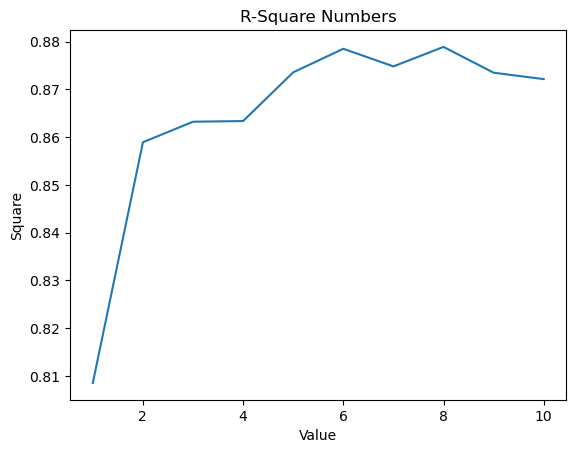

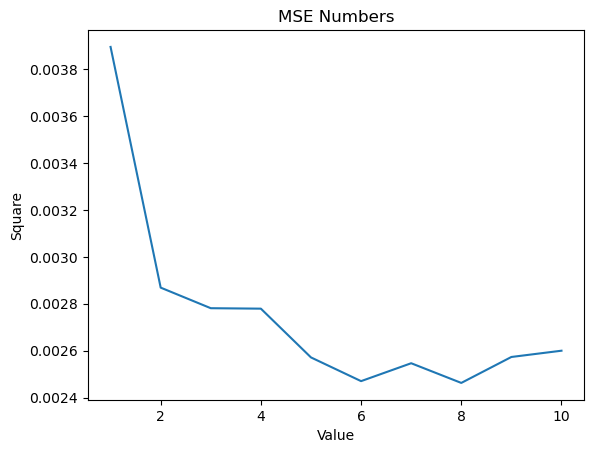

In [ ]:
mse_value = []
r2_value = []
n_number = 10
for i in range(n_number):
    knn = KNeighborsRegressor(n_neighbors=i+1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test).astype('float16')

    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    mse_value.append(mse)
    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)
    r2_value.append(r2)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(range(1, n_number+1), r2_value)

# Set the title and axis labels
ax.set_title("R-Square Numbers")
ax.set_xlabel("Value")
ax.set_ylabel("Square")

# Show the plot
plt.show()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(range(1, n_number+1), mse_value)

# Set the title and axis labels
ax.set_title("MSE Numbers")
ax.set_xlabel("Value")
ax.set_ylabel("Square")

# Show the plot
plt.show()

In [ ]:
RF = RandomForestRegressor(n_estimators=100, max_depth=64, random_state=42)

RF.fit(X_train, y_train.values.ravel())
y_pred = RF.predict(X_test).astype('float16')
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse:.5f}")
print(f"R-squared Score: {r2:.5f}")

Mean Squared Error: 0.00241
R-squared Score: 0.88146


In [ ]:
boosting = AdaBoostRegressor(learning_rate=0.001, random_state=42)                             
boosting.fit(X_train, y_train.values.ravel())
y_pred = boosting.predict(X_test).astype('float16')
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse:.5f}")
print(f"R-squared Score: {r2:.5f}")

Mean Squared Error: 0.00255
R-squared Score: 0.87439


In [ ]:
# Preparation
X = df[feature]
Y = df[target]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))


n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps)
print(n_features)
print(n_outputs)

Total # of sample in whole dataset: 452
Total # of sample in train dataset: 361
Total # of sample in test dataset: 91
7
1
1


In [ ]:
# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

model.summary()

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# # Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose = 2)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

# # Make predictions
# y_pred = model.predict(X_test)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 6, 32)             96        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 2, 64)             4160      
                                                                 
 flatten_12 (Flatten)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 32)                4128      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                     